In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [2]:
# variables
path_excel = r'data.xlsx'
sheetname = r'component_fsm_empty_transport'
dpi = 700
file_path = r'images/Figure3 et_tach_against_peopleserved.pdf'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 14


In [16]:
# create scatterplots by given parameters
def createScatterPlot(
    data,
    ax,
    groupby_col,
    x_col,
    y_col,
    title, 
    x_label,
    y_label,
    markers = ['o', '^', 'v', 's', 'x', 'D', '*'],
    trendline_style = ['-', '--', '-.', ':'],
    log_transform=False,
    marker_size = 100,
    x_min = 0,
    y_min = 0,
    target_ids = None,
    quantile = 0.95
):  
    components = data[groupby_col].unique()
    for i, component in enumerate(components):
        df = data[data[groupby_col]==component]
        color = 'k'
        x_data = df[x_col]
        y_data = df[y_col]
        
        if log_transform:
            # 対数変換を実行
            x_data = np.log(x_data)
        
        ax.scatter(x_data, y_data, marker=markers[i], label=component, color=color, s=marker_size)
        
        if target_ids is None:
            continue
        for target_id in target_ids:
            if target_id in df['datapoint_id'].values:
                idx = df['datapoint_id'] == target_id
                datapoint_name = df.loc[idx, 'datapoint_name'].values[0]
                datapoint_name = '\n'.join(textwrap.wrap(datapoint_name, 15))
                
                x = x_data[idx].values[0]
                y = y_data[idx].values[0]
                if target_id == 38:
                    ax.annotate(datapoint_name, (x * 0.97, y*1.15), xytext=(0, 0), textcoords='offset points', ha='right', va='center', fontsize=14, color='k')
                    ax.plot([x, x * 0.97], [y, y*1.1], linestyle='-', color='k', lw=1)
                else:
                    ax.annotate(datapoint_name, (x * 0.97, y), xytext=(0, 0), textcoords='offset points', ha='right', va='center', fontsize=14, color='k')
                    ax.plot([x, x * 0.97], [y, y], linestyle='-', color='k', lw=1)

    # Add bestfit line
    # remove outlier (filter by quantitle < 0.95 as default)
    q = data[x_col].quantile(quantile)
    filtered_data = data.query(f"{x_col} < @q")
    if log_transform:
        x = np.array(list(np.log(filtered_data[x_col])))
    else:
        x = np.array(list(filtered_data[x_col]))
        
    y = np.array(list(filtered_data[y_col]))
    
    # create least-squares approximation
    A = np.vstack((x ** 2, x, np.ones(len(x)))).T
    v = y.T
    u, residuals, rank, s = np.linalg.lstsq(A, v, rcond=None)
    
    x_graph = np.linspace(min(x), max(x), 100)
    ax.plot(x_graph, x_graph ** 2 * u[0] + x_graph * u[1] + u[2], label='Least squares approximation', color="k", linestyle="--")
                
    ax.set_xlim(left=x_min)
    ax.set_ylim(bottom=y_min)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.grid(which='both')

<function matplotlib.pyplot.show(close=None, block=None)>

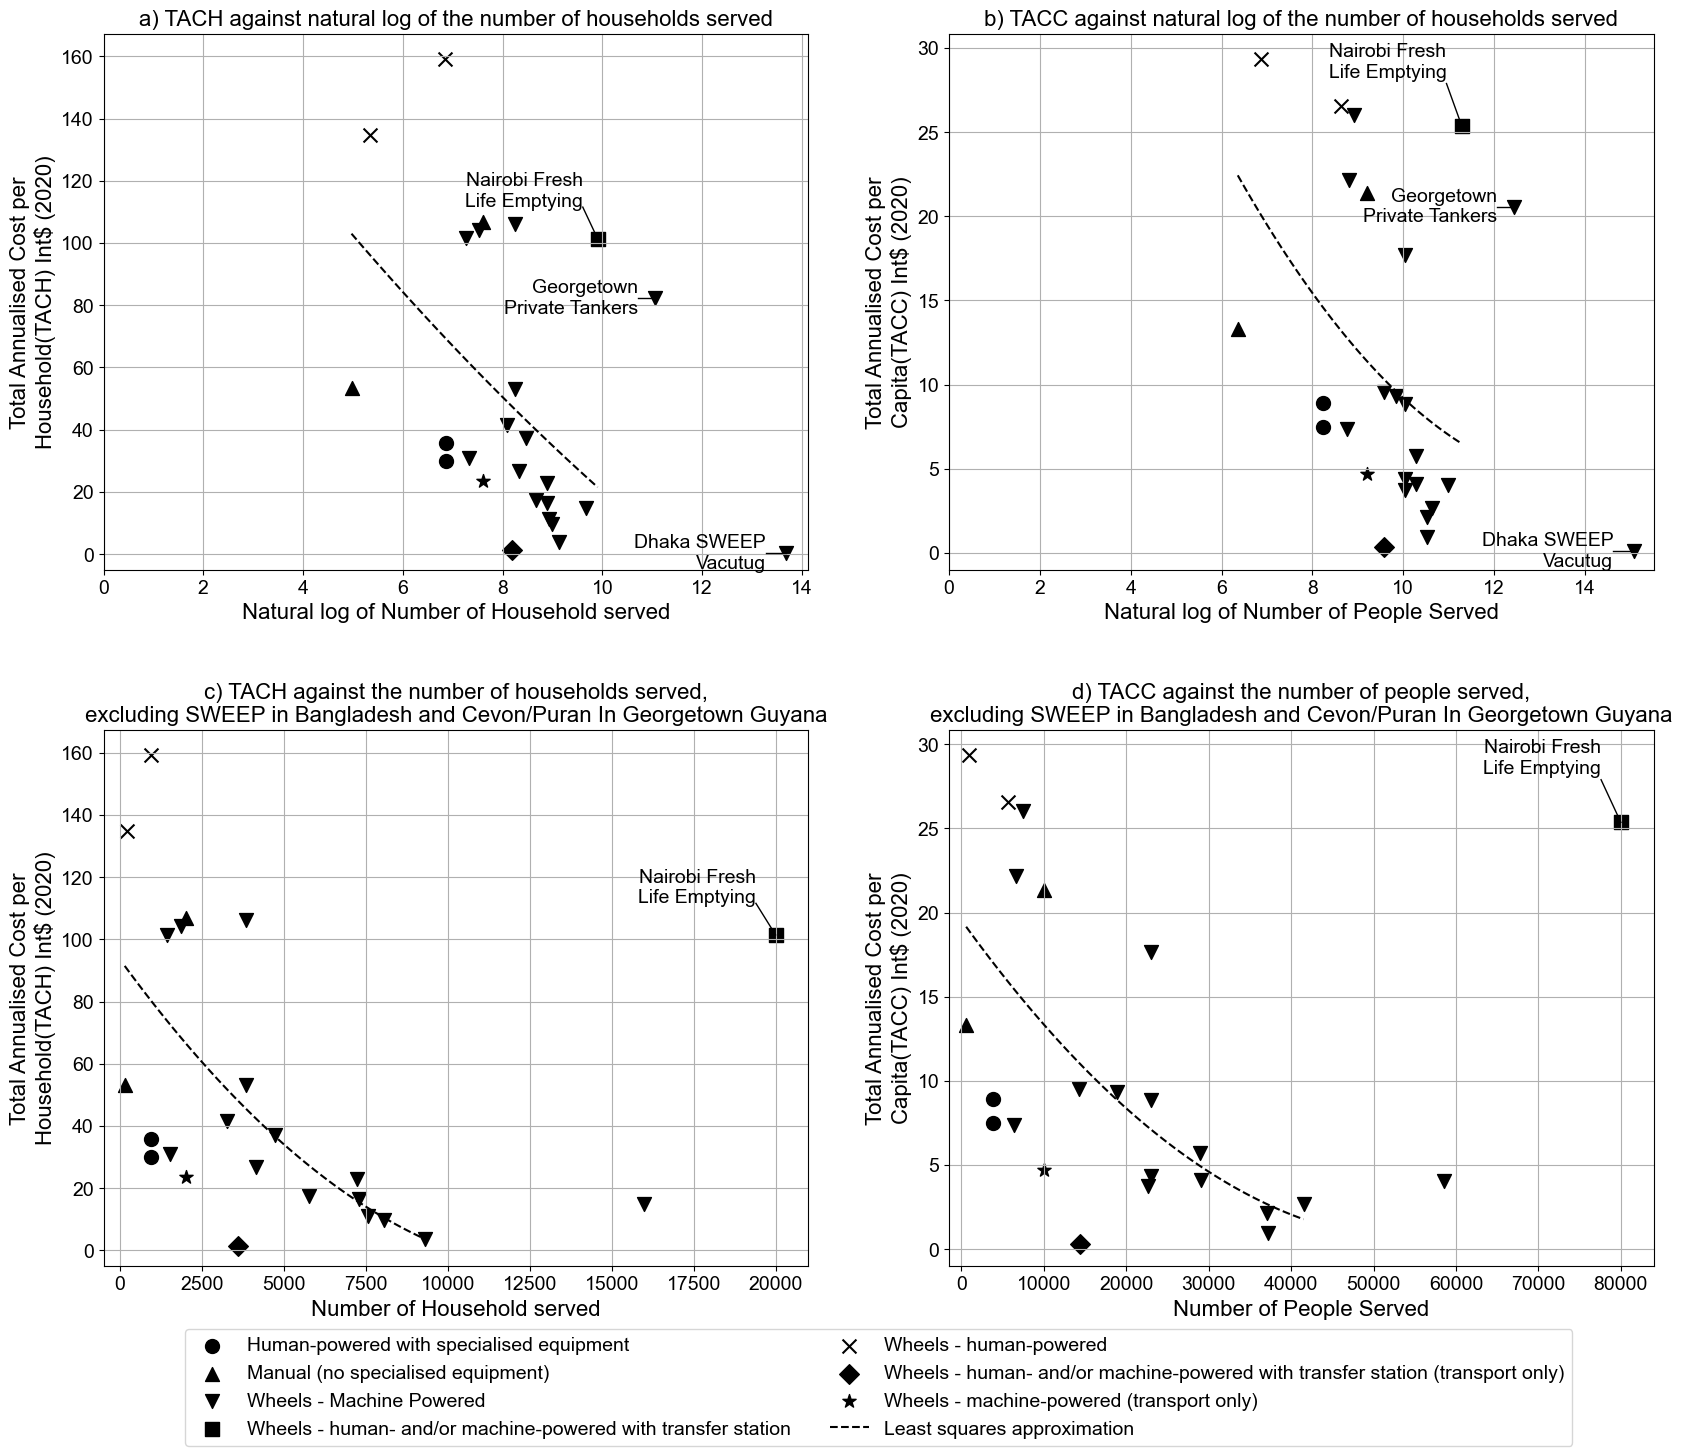

In [17]:
fig = plt.figure(figsize=(20, 16))

# for SWEEP and Georgetown
target_ids = [
    53, # SWEEP, Bangladesh
    48, # Georgetown, Guyana
]

ax1 = fig.add_subplot(2, 2, 1)
data = pd.read_excel(path_excel, sheet_name=sheetname)
createScatterPlot(
    data, 
    ax1,
    groupby_col = 'component',
    x_col = 'num_hh_served',
    y_col = 'tach',
    title = 'a) TACH against natural log of the number of households served',
    x_label = 'Natural log of Number of Household served',
    y_label = 'Total Annualised Cost per\nHousehold(TACH) Int$ (2020)',
    log_transform = True,
    x_min = 0,
    y_min = -5,
    target_ids = target_ids + [38] # Freshlife toilet, Nairobi,
)

ax2 = fig.add_subplot(2, 2, 2)
createScatterPlot(
    data, 
    ax2,
    groupby_col = 'component',
    x_col = 'num_people_served',
    y_col = 'tacc',
    title = 'b) TACC against natural log of the number of households served',
    x_label = 'Natural log of Number of People Served',
    y_label = 'Total Annualised Cost per\nCapita(TACC) Int$ (2020)',
    log_transform = True,
    x_min = 0,
    y_min = -1,
    target_ids = target_ids + [38] # Freshlife toilet, Nairobi,
)

ax3 = fig.add_subplot(2, 2, 3)

filtered_data = data[~data['datapoint_id'].isin(target_ids)]
createScatterPlot(
    filtered_data, 
    ax3,
    groupby_col = 'component',
    x_col = 'num_hh_served',
    y_col = 'tach',
    title = 'c) TACH against the number of households served,\nexcluding SWEEP in Bangladesh and Cevon/Puran In Georgetown Guyana',
    x_label = 'Number of Household served',
    y_label = 'Total Annualised Cost per\nHousehold(TACH) Int$ (2020)',
    log_transform = False,
    y_min = -5,
    x_min = -500,
    target_ids = [38],# Freshlife toilet, Nairobi
)

ax4 = fig.add_subplot(2, 2, 4)
createScatterPlot(
    filtered_data, 
    ax4,
    groupby_col = 'component',
    x_col = 'num_people_served',
    y_col = 'tacc',
    title = 'd) TACC against the number of people served,\nexcluding SWEEP in Bangladesh and Cevon/Puran In Georgetown Guyana',
    x_label = 'Number of People Served',
    y_label = 'Total Annualised Cost per\nCapita(TACC) Int$ (2020)',
    log_transform = False,
    y_min = -1,
    x_min = -1500,
    target_ids = [38],# Freshlife toilet, Nairobi
)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.legend(bbox_to_anchor=(-0.1, -0.1), loc='upper center', ncol=2)
plt.savefig(file_path, format="pdf", dpi=dpi, transparent=True, bbox_inches='tight')
plt.savefig(f"{file_path}.png", format="png", dpi=dpi, transparent=True, bbox_inches='tight')
plt.show